### The primary point of this notebook is to demonstrate how to generate QA images of specific sources.

In [1]:
%pylab
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import animation
from IPython.display import HTML # requires ffmpeg

In [18]:
import pandas as pd
import os
import photutils

In [4]:
from gPhoton import PhotonPipe
from gPhoton.MCUtils import print_inline

In [5]:
import gfcat_utils as gfu

#### Use GJ65 (aka UV Ceti) as the test source.

In [6]:
skypos = (24.76279, -17.94948) # position of UV Ceti
match_radius = 0.005
eclipse = 13656 # This one of the UV Ceti eclipses

#### Download the raw data from MAST

In [7]:
data_directory='../data' # Relative path to the local disk location that data should be written
band = 'NUV' # NUV has ~10x high countrates than FUV for most types of sources

In [8]:
raw6file = gfu.download_raw6(eclipse,band,data_directory=data_directory)

../data/e13656/e13656-nd-raw6.fits.gz already exists.
	Use keyword `force` to re-download.


#### Calibrate the data

In [9]:
photonfile = '{d}/e{e}/e{e}-{b}d.h5'.format(
        d=data_directory, e=eclipse, b='n' if band=='NUV' else 'f') # output filename
print(f'Photon data file: {photonfile}')
if not os.path.exists(photonfile):
    PhotonPipe.photonpipe(raw6file[:-13],band,raw6file=raw6file,verbose=2)
else:
    print('\tAlready exists.')

Photon data file: ../data/e13656/e13656-nd.h5
	Already exists.


In [10]:
xcalfilename = photonfile.replace('.h5','-xcal.h5')
print(f'E[x]tended photon data file: {xcalfilename}')
if not os.path.exists(xcalfilename):
    events = gfu.calibrate_photons(photonfile,band)
    if len(events):
        print('Writing {xcalfilename}'.format(xcalfilename=xcalfilename))
        os.remove(xcalfilename) # Warning re: append. Important that file doesn't already exist!
        with pd.HDFStore(xcalfilename) as store:
            store.append('events',events)
    else:
        raise('There is no valid data in this visit and everything after will fail.')
else:
    print('\tAlready exists.')

E[x]tended photon data file: ../data/e13656/e13656-nd-xcal.h5
	Already exists.


#### Create full-depth images and 120s movies
This is the biggest processing bottleneck. It will hit CPU and memory hard, and little has been done to mitigate that. 32Gb of onboard memory is recommended as a minimum. For unusually bright fields, 128Gb is probably needed.

In [12]:
cntfilename = photonfile.replace(".h5", "-cnt.fits.gz")
movfilename = photonfile.replace(".h5", "-mov.fits.gz")
print(f'Image file: {cntfilename}')
print(f'Movie file: {movfilename}')
# This is the biggest processing bottleneck... will hit CPU and memory hard!
if not os.path.exists(cntfilename) or not os.path.exists(movfilename):
    %time gfu.make_images(eclipse,band,data_directory=data_directory,bins=["",120])
#Useful tip:          This number defines the movie frame duration in seconds.^^^
#                     So setting it to 30 would produce 30-second movies, etc.^^^
else:
    print('\tAlready exist.')

Image file: ../data/e13656/e13656-nd-cnt.fits.gz
Movie file: ../data/e13656/e13656-nd-mov.fits.gz
Reading data from ../data/e13656/e13656-nd-xcal.h5
Integrating ../data/e13656/e13656-nd-cnt.fits
	[816379178.995,816380892.99]
	Generated flag map.of 1                                    
	Generated edge map.
		Writing ../data/e13656/e13656-nd-cnt.fits
		Compressing ../data/e13656/e13656-nd-cnt.fits.gz
Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


/Users/cm/github/gfcat/code/gfcat_utils.py:246: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(image), cmap="Greys_r", origin="lower")
/Users/cm/github/gfcat/code/gfcat_utils.py:247: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool")
/Users/cm/github/gfcat/code/gfcat_utils.py:248: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia")


Integrating ../data/e13656/e13656-nd-mov.fits
	[816379178.995,816380892.99]
		Writing ../data/e13656/e13656-nd-mov.fits                 
		Compressing ../data/e13656/e13656-nd-mov.fits.gz
CPU times: user 1min 56s, sys: 10.4 s, total: 2min 6s
Wall time: 2min 11s


#### The images are structured as follows:
1. Full depth images have "cnt" in the filename (in reference to the mission-produced "count" maps).
    * These have been corrected for detector response, but not exposure time.
    * The calibrated (aka "effective") exposure time appears in the header. So divide the image by this to get the "intensity" map.
    * There are two backplane images.
        1. One is an image of all of the events covered by the hotspot mask.
        2. Another is an image of all of the events >400 "flat pixels" from the center of the detector. (in arcsecs?)
    * The "edge" and "mask" flags are generated by running aperture photometry identically on the backplanes as on the main image. Any amount of edge of mask "flux" within the aperture sets the flag as True.
2. Movie files have "mov" in the filename.
    * The time ranges and effective exposure times for each frame appear in header keywords with the frame index as a suffix, e.g. `EXPTIME_1` for the exposure time of the first frame.
    
Count and movie files are created with identical World Coordinate System (WCS) information. The intention intention is that source _detection_ occur on the full-depth images and then source _measurement_ can occur identically on all of the movie frames.
    
The following convenience functio---`read_image()`---will parse the useful information out of these files.

Opened ../data/e13656/e13656-nd-cnt.fits.gz
	Parsed file header.
	Retrieved flag and edge maps.


<ipython-input-13-364ade16620c>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
<ipython-input-13-364ade16620c>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
<ipython-input-13-364ade16620c>:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish


Time range: [[816379178.995, 816380892.99]]

Exposure time: [1529.69847911154]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CRPIX : 1600.5  1600.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.000416666666666667  0.000416666666666667  
NAXIS : 0  0


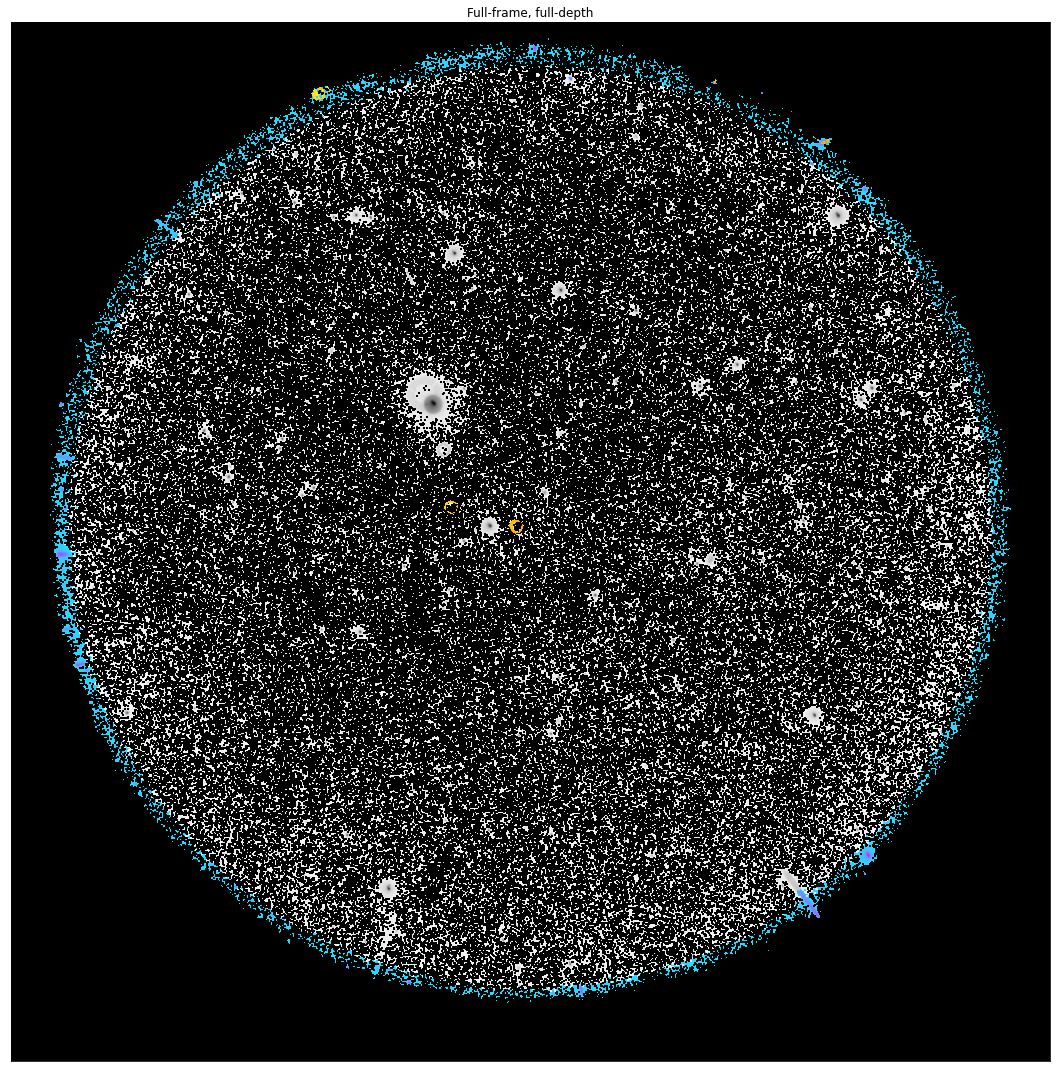

In [13]:
cntmap, flagmap, edgemap, wcs, trange, exptime = gfu.read_image(cntfilename)
plt.figure(figsize=(15, 15))
plt.title('Full-frame, full-depth')
plt.imshow(np.zeros(np.shape(cntmap)),cmap="Greys_r")
plt.imshow(np.log10(cntmap), cmap="Greys", origin="lower")
plt.imshow(np.log10(edgemap), origin="lower", cmap="cool") # "edge" events are blueish
plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia") # "hotspot" events are yellowish
plt.xticks([])
plt.yticks([])
plt.tight_layout()

print(f'Time range: {trange}\n')
print(f'Exposure time: {exptime}\n')
print(f'{wcs}')

Opened ../data/e13656/e13656-nd-mov.fits.gz
	Parsed file header.

15 images frames.

Time ranges: [[816379178.995, 816379298.995], [816379298.995, 816379418.995], [816379418.995, 816379538.995], [816379538.995, 816379658.995], [816379658.995, 816379778.995], [816379778.995, 816379898.995], [816379898.995, 816380018.995], [816380018.995, 816380138.995], [816380138.995, 816380258.995], [816380258.995, 816380378.995], [816380378.995, 816380498.995], [816380498.995, 816380618.995], [816380618.995, 816380738.995], [816380738.995, 816380858.995], [816380858.995, 816380978.995]]

Exposure times: [99.89534387874362, 108.2948546857536, 108.5475370233458, 100.9936855071996, 108.6073180701725, 108.9587637063089, 109.0084534329608, 109.0391590492263, 109.0225789172311, 108.9881125104146, 108.8282169828098, 104.2939701664094, 108.4074025359119, 108.2169646598949, 28.59566196115353]

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 24.707145171748  -17.96955374296633  
CR

<ipython-input-14-a6d89b08c6a2>:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(frame/exptimes[i]), cmap="Greys", origin="lower", animated=True),
<ipython-input-14-a6d89b08c6a2>:22: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap), origin="lower", cmap="cool", animated=True),
<ipython-input-14-a6d89b08c6a2>:23: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia", animated=True),


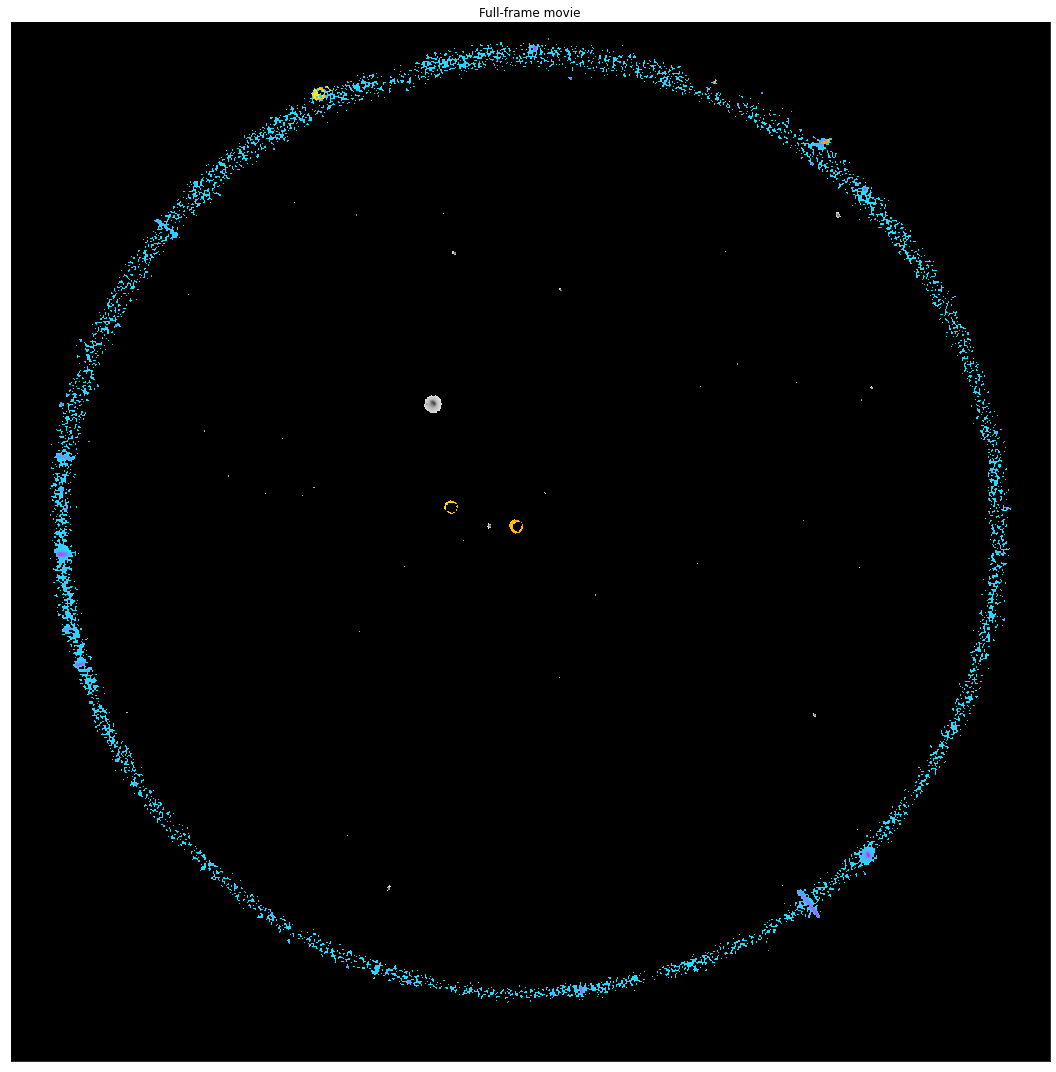

In [14]:
# This generates an animated movie of the scene and can take a few minutes...
# But it's worth it. The end result is really neat.
movmap, _, _, wcs, tranges, exptimes = gfu.read_image(movfilename)
    
print(f'\n{len(movmap)} images frames.\n')
print(f'Time ranges: {tranges}\n')
print(f'Exposure times: {exptimes}\n')
print(f'{wcs}')

# Create an animated image
fig = plt.figure(figsize=(15,15))
plt.title('Full-frame movie')
plt.xticks([])
plt.yticks([])
plt.tight_layout()

ims = []
for i,frame in enumerate(movmap[:-1]): # eliminate the last frame, which always has lower exposure
    ims.append([
        plt.imshow(np.zeros(np.shape(frame)),cmap="Greys_r", animated=True),
        plt.imshow(np.log10(frame/exptimes[i]), cmap="Greys", origin="lower", animated=True),
        plt.imshow(np.log10(edgemap), origin="lower", cmap="cool", animated=True),
        plt.imshow(np.log10(flagmap), origin="lower", cmap="Wistia", animated=True),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml()) # for an interactive animation

#NOTE: I don't know why this is displaying a duplicate image under the movie or how to make it stop doing that.

#### Generate an image stamp of the target source

<ipython-input-21-81ffd0587ecf>:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
<ipython-input-21-81ffd0587ecf>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
<ipython-input-21-81ffd0587ecf>:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')


([], [])

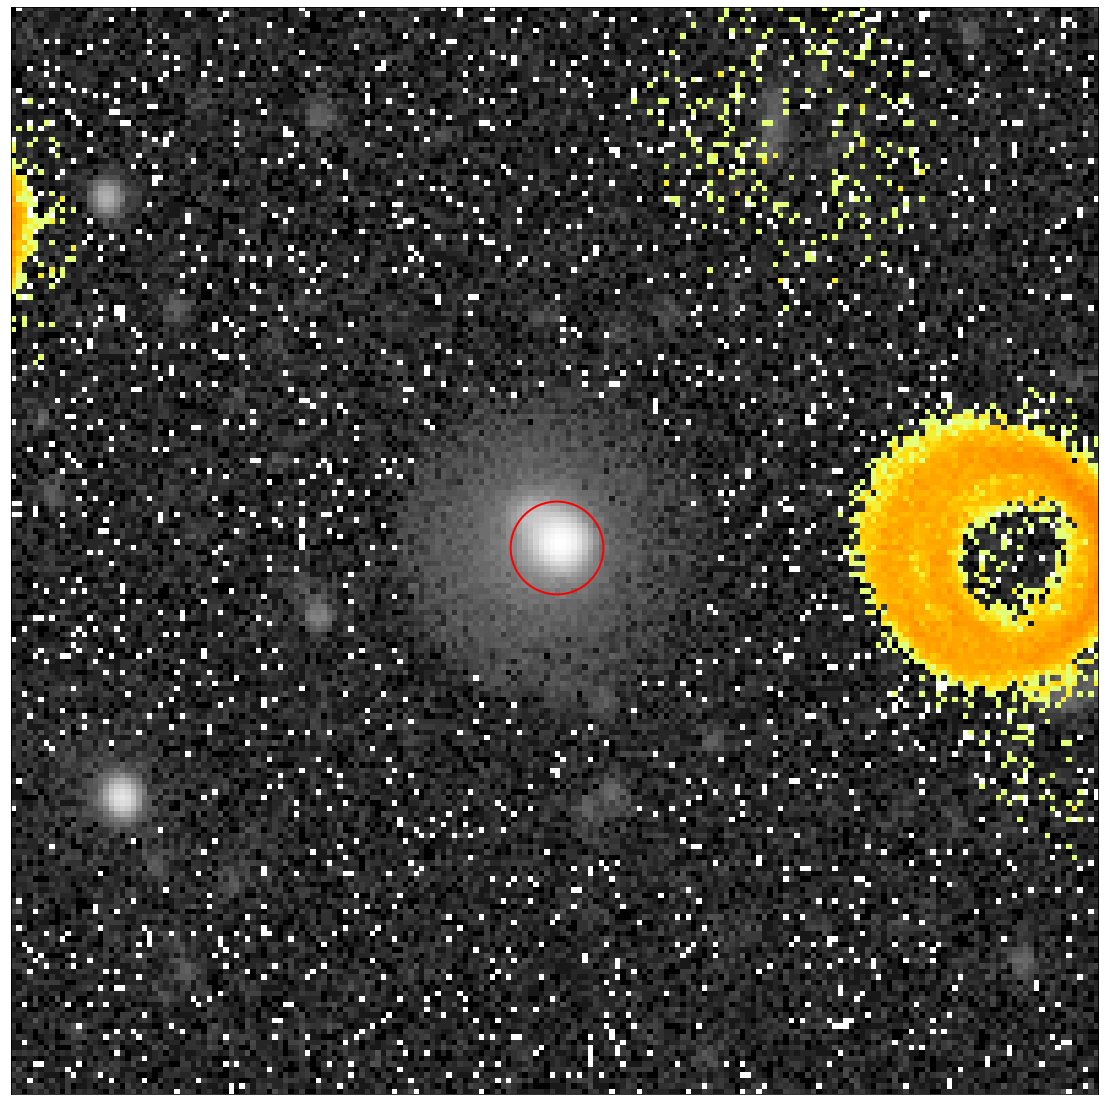

In [21]:
sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # (xcenter, ycenter) copied from previous notebook
plt.figure(figsize=(20, 20))
plt.imshow(np.log10(cntmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Greys_r')
plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool')
plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia')
# Now overplot the aperture
photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1)
plt.xticks([])
plt.yticks([])

#### And generate an movie stamp. Why not? It's the future.

<ipython-input-22-1af678794158>:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(frame[y - sz : y + sz, x - sz : x + sz]/exptimes[i]),origin='lower',cmap='Greys_r', animated=True),
<ipython-input-22-1af678794158>:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
<ipython-input-22-1af678794158>:14: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/cm/opt/miniconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/cm/opt/miniconda3/lib/p

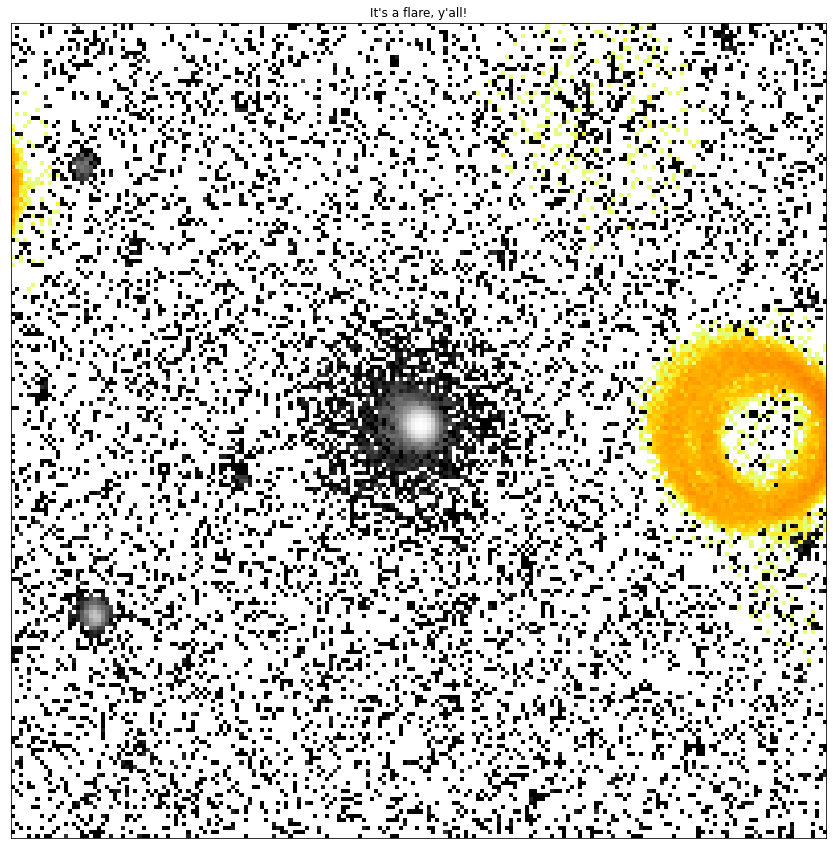

In [22]:
fig = plt.figure(figsize=(15,15))
plt.title("It's a flare, y'all!")
plt.xticks([])
plt.yticks([])

sz = 100 # half height / width of stamp in pixels
x,y = (1475, 1647) # (xcenter, ycenter) copied from previous notebook

ims = []
for i,frame in enumerate(movmap[:-1]):
    ims.append([
        plt.imshow(np.log10(frame[y - sz : y + sz, x - sz : x + sz]/exptimes[i]),origin='lower',cmap='Greys_r', animated=True),
        plt.imshow(np.log10(edgemap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='cool', animated=True),
        plt.imshow(np.log10(flagmap[y - sz : y + sz, x - sz : x + sz]),origin='lower',cmap='Wistia', animated=True),
        #photutils.CircularAperture([sz,sz], r=8.533333333333326).plot(color='red', lw=2, alpha=1),
    ])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat=True)

HTML(ani.to_html5_video())
#HTML(ani.to_jshtml())

#NOTE: I don't know why this is displaying an image under the movie or how to make it stop.